# Customer Support Utterance Clustering Analysis

**Dataset:** `bitext/Bitext-customer-support-llm-chatbot-training-dataset`  
**Source:** HuggingFace Datasets Hub

---

## Pipeline

| Step | What | Tool |
|------|------|------|
| 1 | **Embed** utterances | `all-MiniLM-L6-v2` (384-dim sentence transformer) |
| 2 | **Cluster** with HDBSCAN | UMAP reduction → HDBSCAN (no need to pre-specify *k*) |
| 3 | **Evaluate** against ground-truth | ARI & NMI vs `intent` (27 classes) and `category` (11 classes) |
| 4 | **Label** clusters post-hoc | TF-IDF top terms + optional LLM labeling |

## 1. Setup & Imports

In [1]:
# All dependencies are managed via pyproject.toml + uv
# To install/sync:  uv sync
# To register the Jupyter kernel:
#   uv run python -m ipykernel install --user --name contact-center --display-name "Contact Center (Python 3.13)"
# Then select the "Contact Center (Python 3.13)" kernel in Jupyter.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import warnings

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (12, 6)

print("All libraries loaded.")

All libraries loaded.


## 2. Load Data

In [3]:
dataset = load_dataset(
    "bitext/Bitext-customer-support-llm-chatbot-training-dataset",
    split="train"
)
df = dataset.to_pandas()
print(f"Loaded {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"Categories: {df['category'].nunique()}  |  Intents: {df['intent'].nunique()}")
df.head(3)

Loaded 26,872 rows, 5 columns
Categories: 11  |  Intents: 27


,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...


In [4]:
# Encode ground-truth labels as integers for metric computation
le_intent = LabelEncoder()
le_category = LabelEncoder()
df["intent_label"] = le_intent.fit_transform(df["intent"])
df["category_label"] = le_category.fit_transform(df["category"])

print("Ground-truth label encoding:")
print(f"  intent_label:   {df['intent_label'].nunique()} unique values (0–{df['intent_label'].max()})")
print(f"  category_label: {df['category_label'].nunique()} unique values (0–{df['category_label'].max()})")

Ground-truth label encoding:
  intent_label:   27 unique values (0–26)
  category_label: 11 unique values (0–10)


## 3. Embed Utterances with Sentence Transformer

**Model:** `all-MiniLM-L6-v2` — produces 384-dimensional embeddings, optimised for short texts.  
Swap to `BAAI/bge-base-en-v1.5` (768-dim) or `all-mpnet-base-v2` by changing `MODEL_NAME`.

In [5]:
MODEL_NAME = "all-MiniLM-L6-v2"

model = SentenceTransformer(MODEL_NAME)
print(f"Model loaded: {MODEL_NAME}")
print(f"Max sequence length: {model.max_seq_length}")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model loaded: all-MiniLM-L6-v2
Max sequence length: 256


In [6]:
instructions = df["instruction"].tolist()
embeddings = model.encode(instructions, show_progress_bar=True, batch_size=256)
print(f"\nEmbeddings shape: {embeddings.shape}")
print(f"Embedding dtype:  {embeddings.dtype}")

Batches:   0%|          | 0/105 [00:00<?, ?it/s]


Embeddings shape: (26872, 384)
Embedding dtype:  float32


## 4. Dimensionality Reduction (UMAP)

Two separate UMAP projections:
- **Clustering UMAP** → 15 dims with `min_dist=0.0` (tight packing for HDBSCAN)
- **Visualization UMAP** → 2 dims with `min_dist=0.1` (spread for scatter plots)

In [7]:
%%time
# Clustering-focused UMAP
umap_clustering = umap.UMAP(
    n_components=15,
    n_neighbors=15,
    min_dist=0.0,
    metric="cosine",
    random_state=42,
    verbose=True
)
embeddings_umap_cluster = umap_clustering.fit_transform(embeddings)
print(f"Clustering UMAP shape: {embeddings_umap_cluster.shape}")

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=15, n_jobs=1, random_state=42, verbose=True)
Sat Feb 14 16:53:17 2026 Construct fuzzy simplicial set
Sat Feb 14 16:53:17 2026 Finding Nearest Neighbors
Sat Feb 14 16:53:17 2026 Building RP forest with 13 trees
Sat Feb 14 16:53:19 2026 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Sat Feb 14 16:53:23 2026 Finished Nearest Neighbor Search
Sat Feb 14 16:53:24 2026 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Feb 14 16:53:38 2026 Finished embedding
Clustering UMAP shape: (26872, 15)
CPU times: user 20.8 s, sys: 386 ms, total: 21.2 s
Wall time: 21.1 s


In [8]:
%%time
# Visualization-focused UMAP
umap_viz = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
    verbose=True
)
embeddings_2d = umap_viz.fit_transform(embeddings)
df["umap_x"] = embeddings_2d[:, 0]
df["umap_y"] = embeddings_2d[:, 1]
print(f"Visualization UMAP shape: {embeddings_2d.shape}")

UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, random_state=42, verbose=True)
Sat Feb 14 16:53:38 2026 Construct fuzzy simplicial set
Sat Feb 14 16:53:38 2026 Finding Nearest Neighbors
Sat Feb 14 16:53:38 2026 Building RP forest with 13 trees
Sat Feb 14 16:53:38 2026 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Sat Feb 14 16:53:39 2026 Finished Nearest Neighbor Search
Sat Feb 14 16:53:39 2026 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Feb 14 16:53:50 2026 Finished embedding
Visualization UMAP shape: (26872, 2)
CPU times: user 12.4 s, sys: 113 ms, total: 12.5 s
Wall time: 12.5 s


## 5. Visualize Ground-Truth Labels in UMAP Space

Before clustering, let's see how well the sentence embeddings separate the known intents and categories.

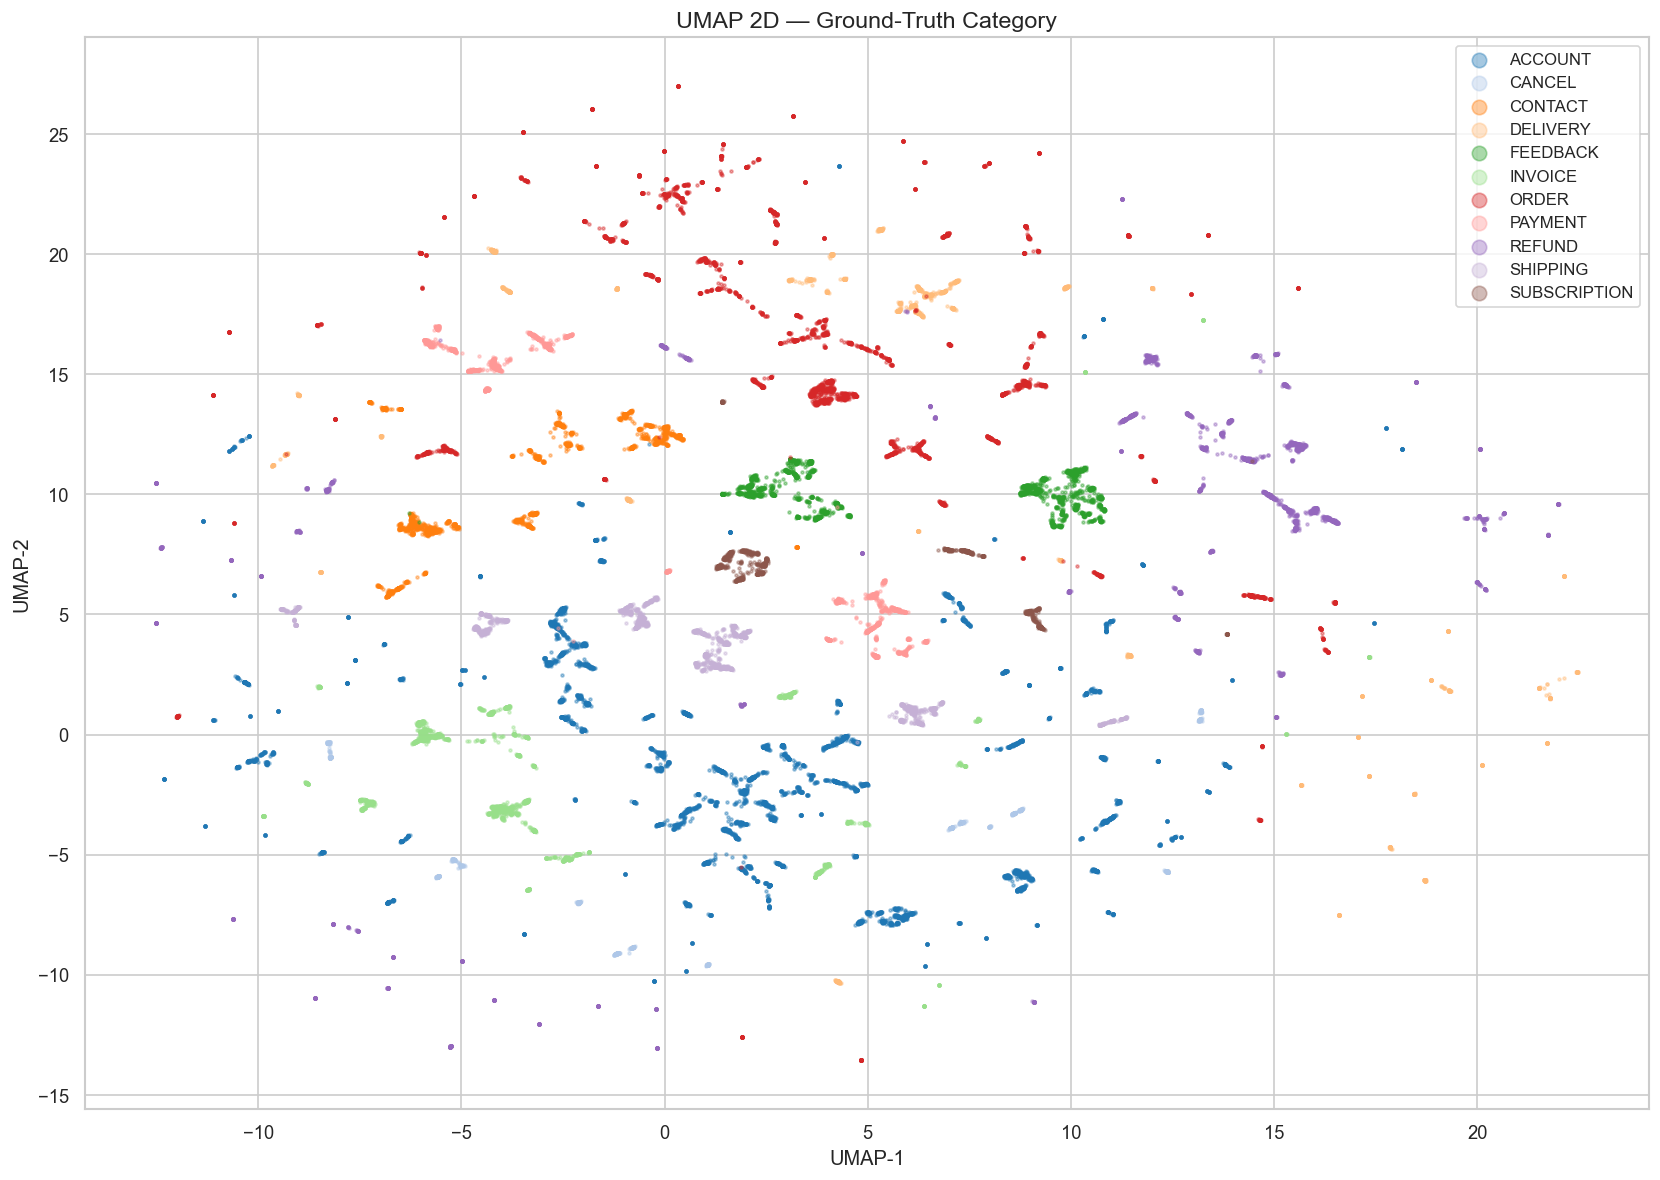

In [9]:
# Ground truth: CATEGORY (11 classes)
fig, ax = plt.subplots(figsize=(14, 10))
categories = sorted(df["category"].unique())
palette = sns.color_palette("tab20", len(categories))

for i, cat in enumerate(categories):
    mask = df["category"] == cat
    ax.scatter(df.loc[mask, "umap_x"], df.loc[mask, "umap_y"],
               c=[palette[i]], label=cat, s=3, alpha=0.4)

ax.legend(markerscale=5, fontsize=10, loc="best")
ax.set_title("UMAP 2D — Ground-Truth Category", fontsize=14)
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
plt.tight_layout()
plt.show()

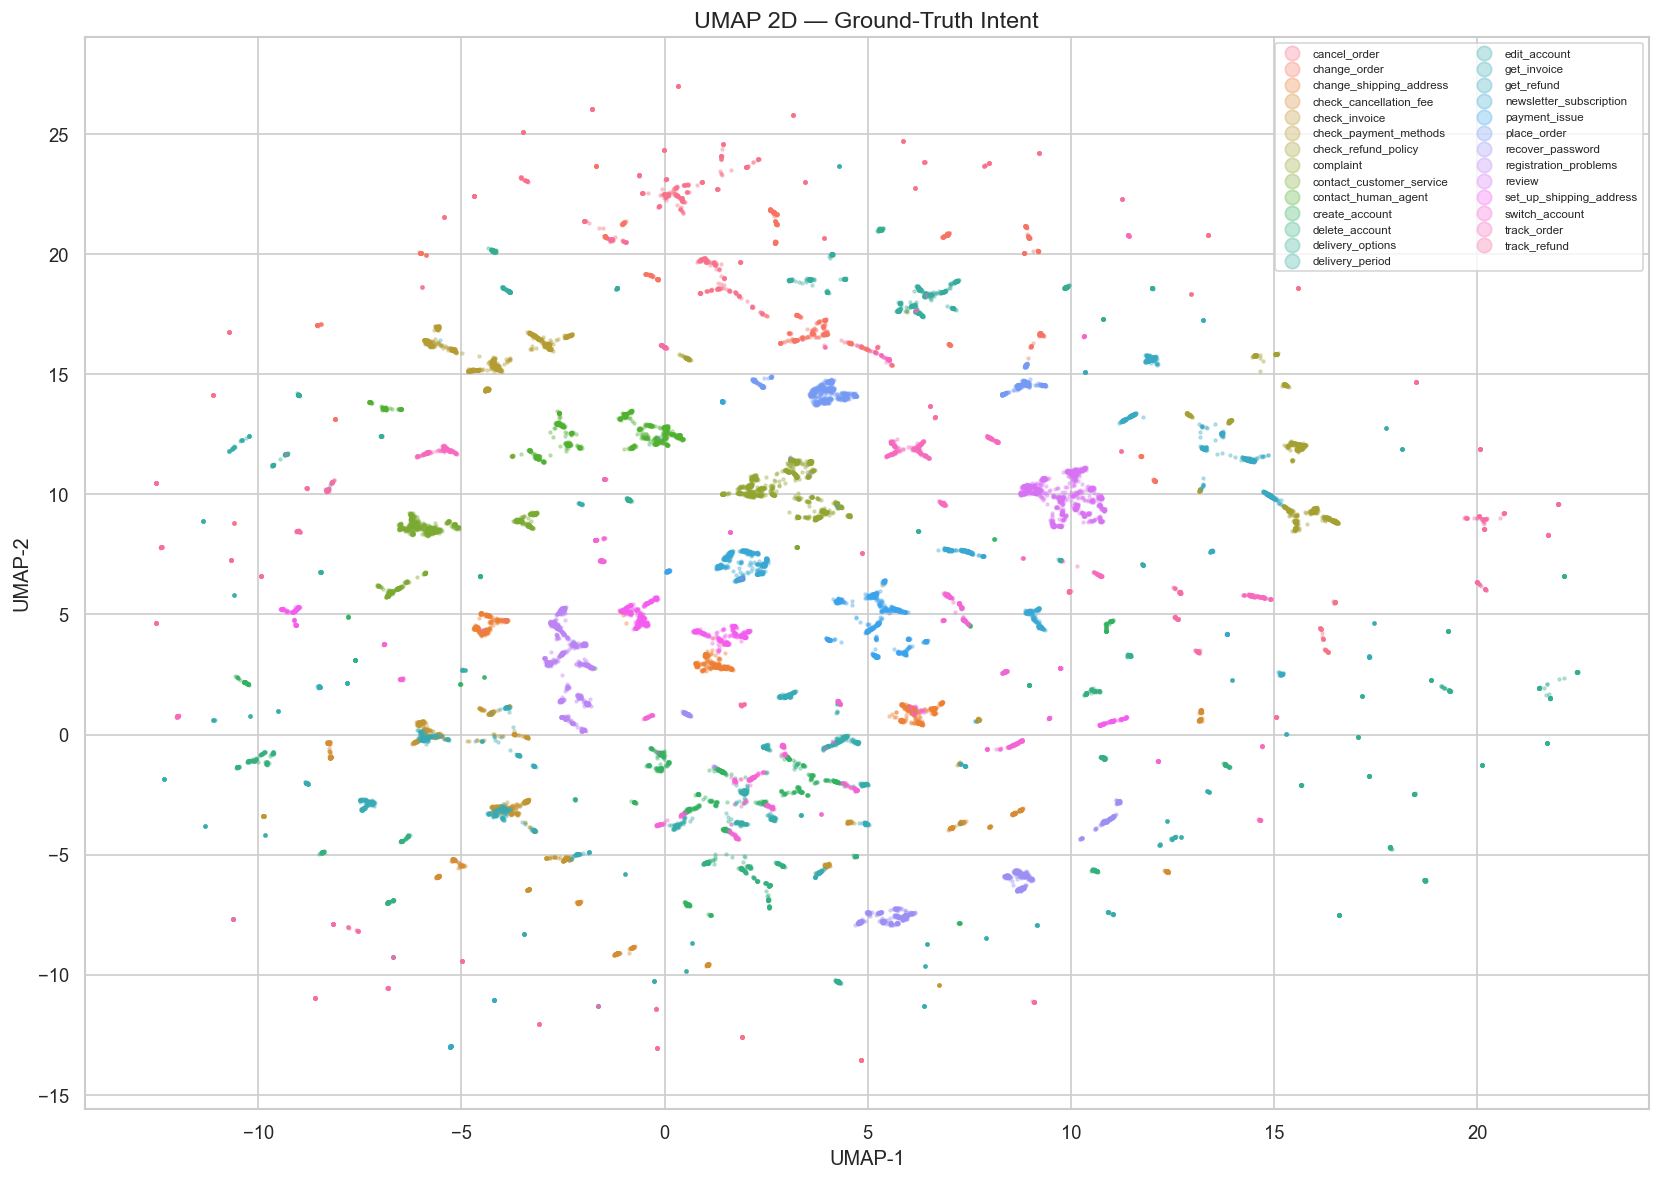

In [10]:
# Ground truth: INTENT (27 classes)
fig, ax = plt.subplots(figsize=(14, 10))
intents = sorted(df["intent"].unique())
palette_intent = sns.color_palette("husl", len(intents))

for i, intent in enumerate(intents):
    mask = df["intent"] == intent
    ax.scatter(df.loc[mask, "umap_x"], df.loc[mask, "umap_y"],
               c=[palette_intent[i]], label=intent, s=3, alpha=0.3)

ax.legend(markerscale=5, fontsize=7, loc="best", ncol=2)
ax.set_title("UMAP 2D — Ground-Truth Intent", fontsize=14)
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
plt.tight_layout()
plt.show()

## 6. HDBSCAN Clustering

**Why HDBSCAN?**
- Does **not** require pre-specifying *k*
- Identifies **noise points** (label = −1) rather than forcing every point into a cluster
- Works well with UMAP-reduced embeddings

We first run a parameter sweep over `min_cluster_size`, then pick the best setting.

In [11]:
# Parameter sweep: min_cluster_size
sweep_results = []
for mcs in [25, 50, 100, 200, 500]:
    c = hdbscan.HDBSCAN(
        min_cluster_size=mcs,
        min_samples=10,
        metric="euclidean",
        cluster_selection_method="eom"
    )
    labels = c.fit_predict(embeddings_umap_cluster)
    n_c = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = (labels == -1).sum()
    # Quick ARI against intent (excluding noise)
    valid = labels != -1
    ari = adjusted_rand_score(df.loc[valid, "intent_label"], labels[valid]) if valid.sum() > 0 else 0
    sweep_results.append({
        "min_cluster_size": mcs,
        "n_clusters": n_c,
        "noise_pct": round(n_noise / len(df) * 100, 1),
        "ari_vs_intent": round(ari, 4)
    })

sweep_df = pd.DataFrame(sweep_results)
print("HDBSCAN Parameter Sweep")
print("(Ground truth has 27 intents / 11 categories)\n")
sweep_df

HDBSCAN Parameter Sweep
(Ground truth has 27 intents / 11 categories)



,min_cluster_size,n_clusters,noise_pct,ari_vs_intent
0,25,394,9.0,0.1678
1,50,229,8.8,0.2606
2,100,106,8.5,0.4228
3,200,56,12.6,0.5304
4,500,21,18.7,0.6961


In [12]:
# Select the best min_cluster_size (highest ARI against intent)
best_mcs = sweep_df.loc[sweep_df["ari_vs_intent"].idxmax(), "min_cluster_size"]
print(f"Best min_cluster_size by ARI: {best_mcs}")

# Final HDBSCAN run
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=int(best_mcs),
    min_samples=10,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)
cluster_labels = clusterer.fit_predict(embeddings_umap_cluster)
df["hdbscan_cluster"] = cluster_labels

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = (cluster_labels == -1).sum()

print(f"\nClusters found:  {n_clusters}")
print(f"Noise points:    {n_noise:,} ({n_noise / len(df) * 100:.1f}%)")
print(f"\nCluster size stats (excl. noise):")
print(pd.Series(cluster_labels[cluster_labels != -1]).value_counts().describe().round(1))

Best min_cluster_size by ARI: 500

Clusters found:  21
Noise points:    5,022 (18.7%)

Cluster size stats (excl. noise):
count      21.0
mean     1040.5
std       530.3
min       506.0
25%       625.0
50%       996.0
75%      1007.0
max      2248.0
Name: count, dtype: float64


## 7. Visualize HDBSCAN Clusters

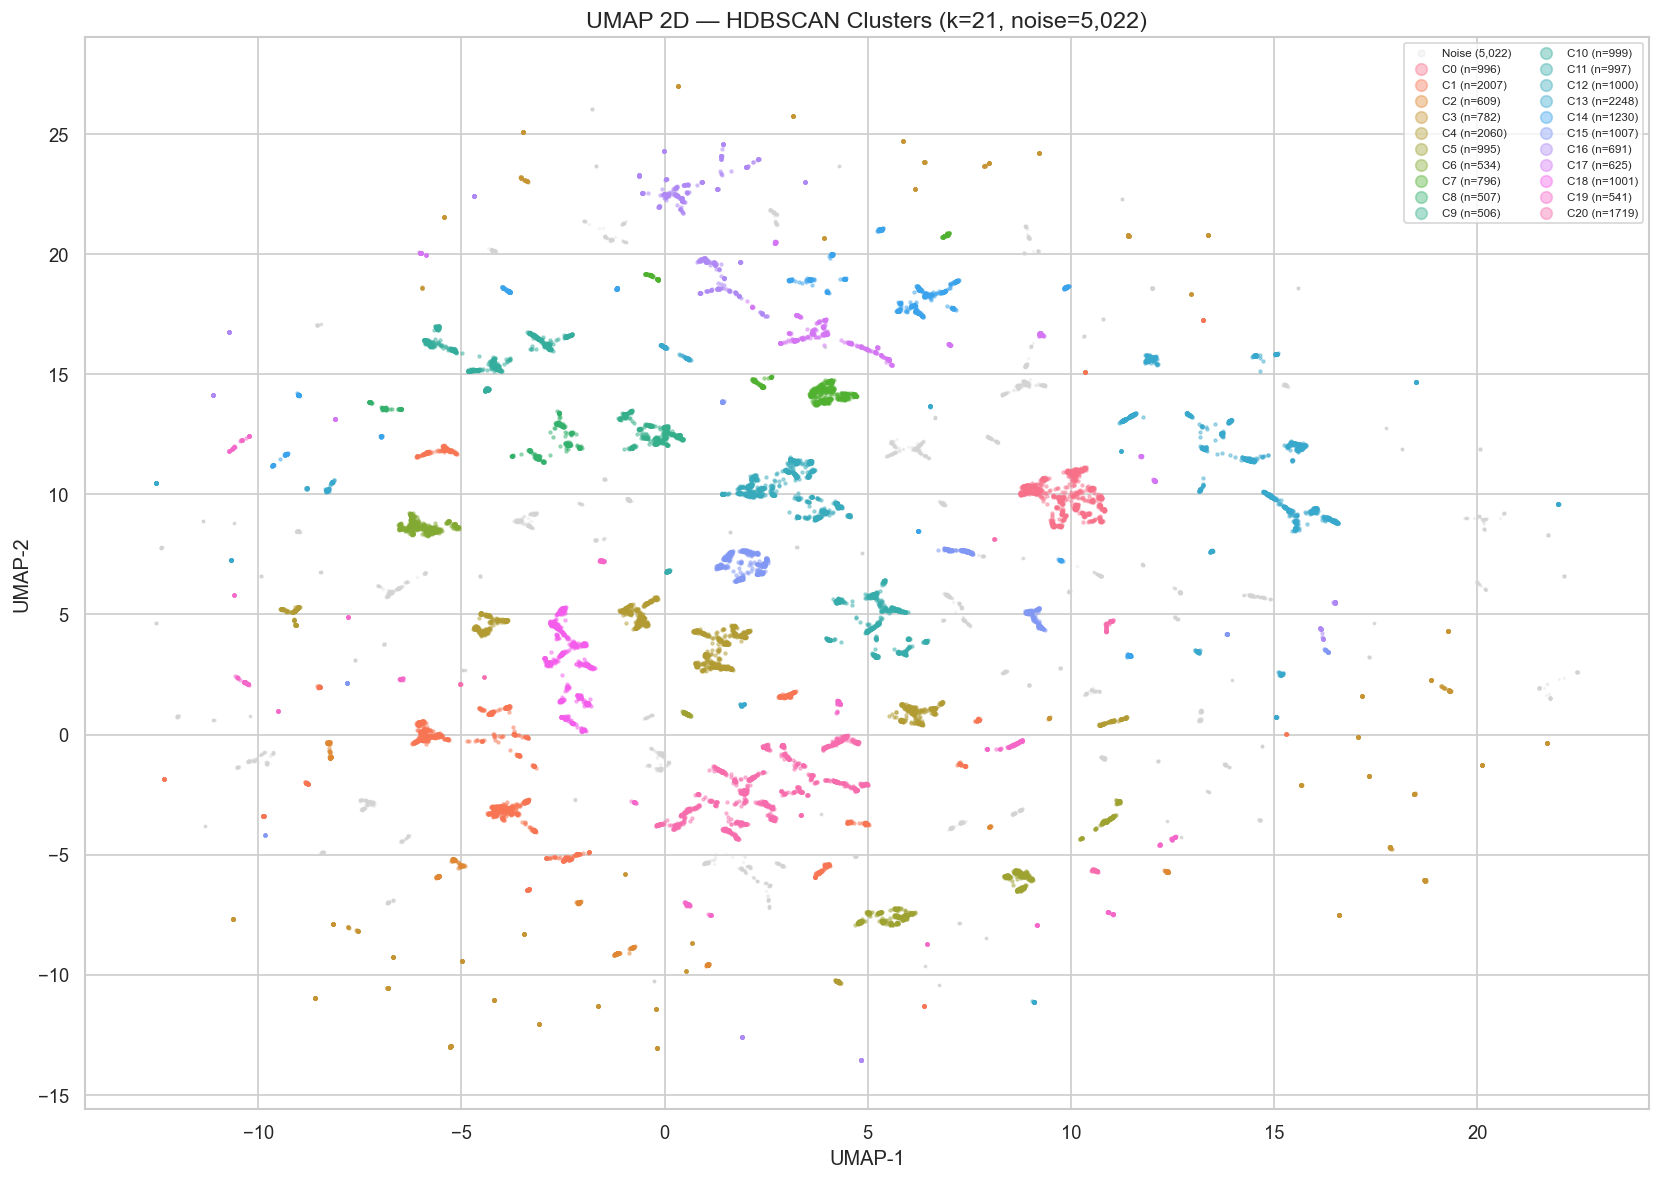

In [13]:
# UMAP scatter colored by HDBSCAN cluster
fig, ax = plt.subplots(figsize=(14, 10))

unique_clusters = sorted(df["hdbscan_cluster"].unique())
noise_mask = df["hdbscan_cluster"] == -1
non_noise = [c for c in unique_clusters if c != -1]
palette_hdb = sns.color_palette("husl", len(non_noise))

# Noise in grey
if noise_mask.any():
    ax.scatter(df.loc[noise_mask, "umap_x"], df.loc[noise_mask, "umap_y"],
               c="lightgrey", s=1, alpha=0.2, label=f"Noise ({noise_mask.sum():,})")

# Clusters
for i, cid in enumerate(non_noise):
    mask = df["hdbscan_cluster"] == cid
    ax.scatter(df.loc[mask, "umap_x"], df.loc[mask, "umap_y"],
               c=[palette_hdb[i]], label=f"C{cid} (n={mask.sum()})", s=3, alpha=0.4)

ax.set_title(f"UMAP 2D — HDBSCAN Clusters (k={len(non_noise)}, noise={noise_mask.sum():,})", fontsize=14)
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
if len(non_noise) <= 35:
    ax.legend(markerscale=4, fontsize=7, loc="best", ncol=2)
plt.tight_layout()
plt.show()

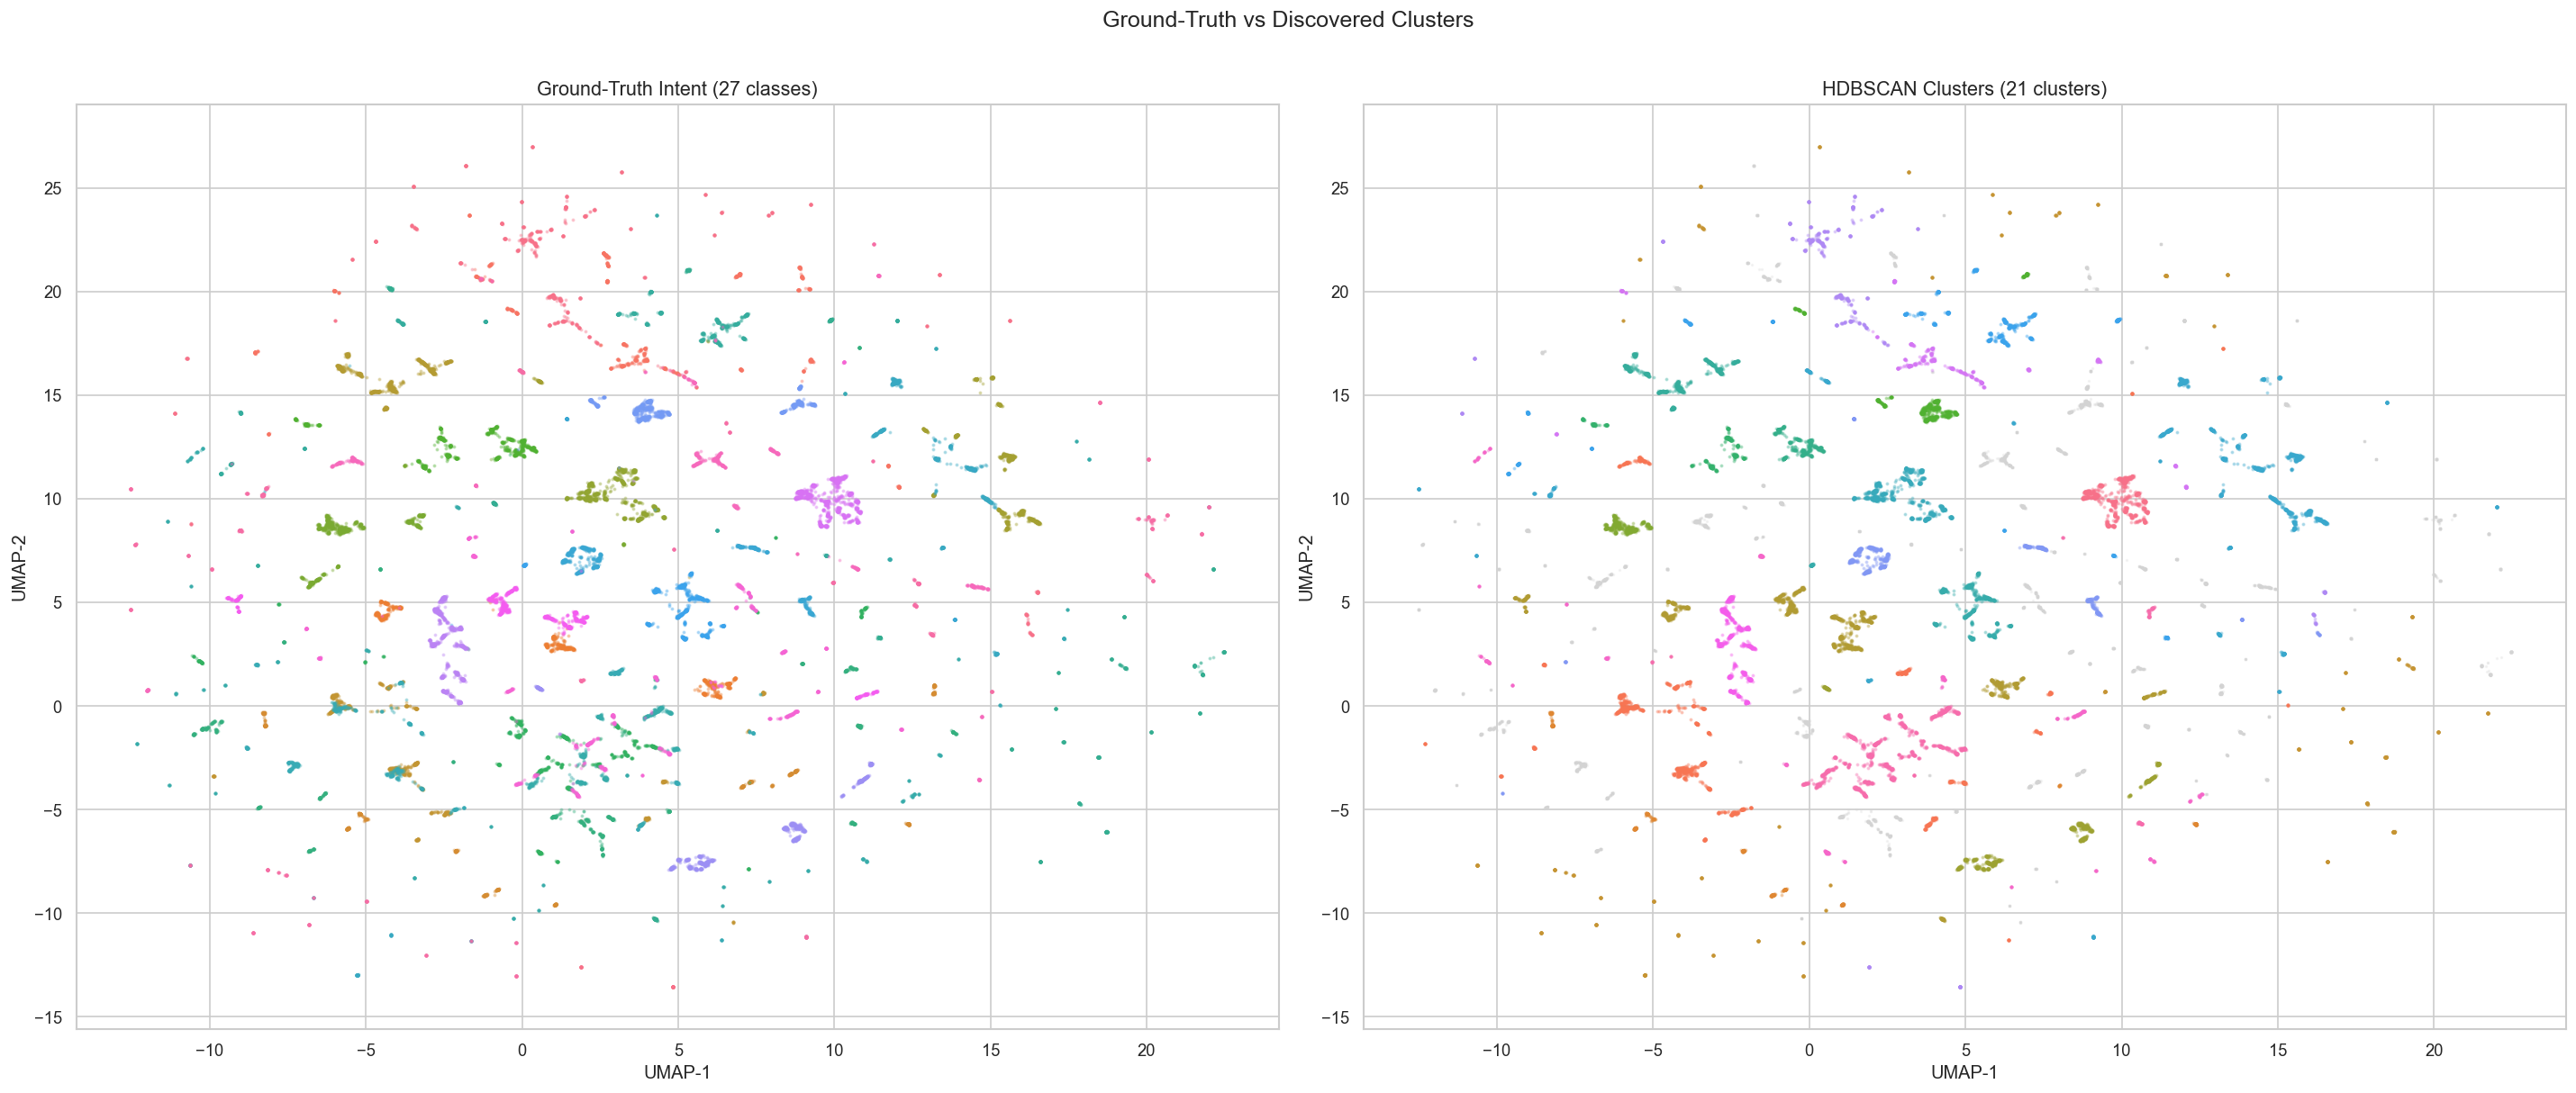

In [14]:
# Side-by-side: Ground-Truth Intent vs HDBSCAN Clusters
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# LEFT: Ground-truth intent
ax = axes[0]
intents_sorted = sorted(df["intent"].unique())
palette_gt = sns.color_palette("husl", len(intents_sorted))
for i, intent in enumerate(intents_sorted):
    mask = df["intent"] == intent
    ax.scatter(df.loc[mask, "umap_x"], df.loc[mask, "umap_y"],
               c=[palette_gt[i]], s=2, alpha=0.3)
ax.set_title("Ground-Truth Intent (27 classes)", fontsize=13)
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")

# RIGHT: HDBSCAN clusters
ax = axes[1]
if noise_mask.any():
    ax.scatter(df.loc[noise_mask, "umap_x"], df.loc[noise_mask, "umap_y"],
               c="lightgrey", s=1, alpha=0.2)
for i, cid in enumerate(non_noise):
    mask = df["hdbscan_cluster"] == cid
    ax.scatter(df.loc[mask, "umap_x"], df.loc[mask, "umap_y"],
               c=[palette_hdb[i]], s=2, alpha=0.3)
ax.set_title(f"HDBSCAN Clusters ({len(non_noise)} clusters)", fontsize=13)
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")

plt.suptitle("Ground-Truth vs Discovered Clusters", fontsize=15, y=1.01)
plt.tight_layout()
plt.show()

## 8. Evaluate Clustering Quality

| Metric | Range | Interpretation |
|--------|-------|----------------|
| **ARI** (Adjusted Rand Index) | [−1, 1] | 1 = perfect, 0 = random |
| **NMI** (Normalized Mutual Information) | [0, 1] | 1 = perfect correlation |

Noise points (label = −1) are **excluded** from evaluation.

In [15]:
valid_mask = df["hdbscan_cluster"] != -1
pred = df.loc[valid_mask, "hdbscan_cluster"]

# ARI & NMI against intent (27 classes)
ari_intent = adjusted_rand_score(df.loc[valid_mask, "intent_label"], pred)
nmi_intent = normalized_mutual_info_score(df.loc[valid_mask, "intent_label"], pred)

# ARI & NMI against category (11 classes)
ari_category = adjusted_rand_score(df.loc[valid_mask, "category_label"], pred)
nmi_category = normalized_mutual_info_score(df.loc[valid_mask, "category_label"], pred)

metrics_df = pd.DataFrame({
    "Ground Truth": ["Intent (27)", "Category (11)"],
    "ARI": [ari_intent, ari_category],
    "NMI": [nmi_intent, nmi_category]
}).round(4)

print(f"Evaluated on {valid_mask.sum():,} / {len(df):,} points (excl. {(~valid_mask).sum():,} noise)\n")
metrics_df

Evaluated on 21,850 / 26,872 points (excl. 5,022 noise)



,Ground Truth,ARI,NMI
0,Intent (27),0.6961,0.8751
1,Category (11),0.6317,0.8368


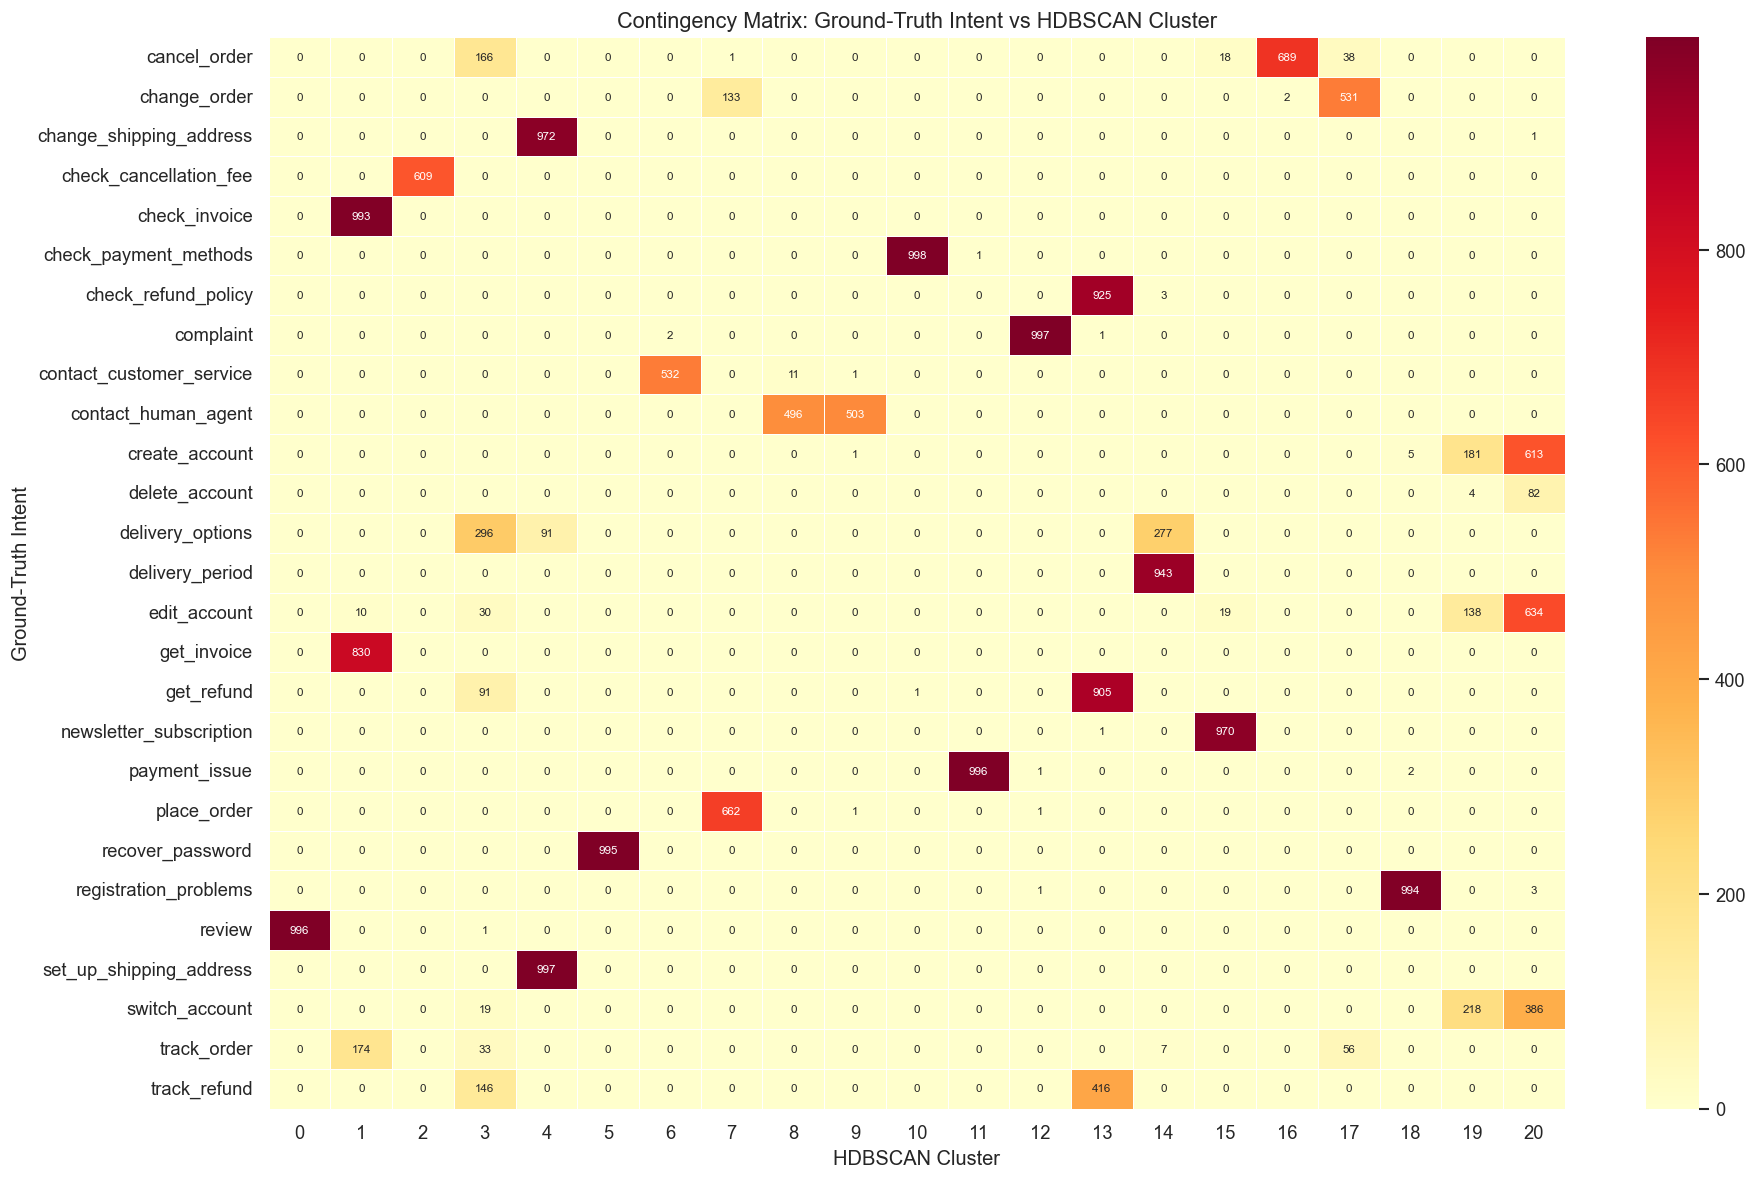

In [16]:
# Contingency matrix: Intent vs HDBSCAN Cluster
ct_intent = pd.crosstab(df.loc[valid_mask, "intent"], df.loc[valid_mask, "hdbscan_cluster"])

fig, ax = plt.subplots(figsize=(max(16, len(ct_intent.columns) * 0.6), 10))
sns.heatmap(ct_intent, annot=True, fmt="d", cmap="YlOrRd", ax=ax,
            linewidths=0.3, annot_kws={"size": 7})
ax.set_title("Contingency Matrix: Ground-Truth Intent vs HDBSCAN Cluster", fontsize=13)
ax.set_xlabel("HDBSCAN Cluster")
ax.set_ylabel("Ground-Truth Intent")
plt.tight_layout()
plt.show()

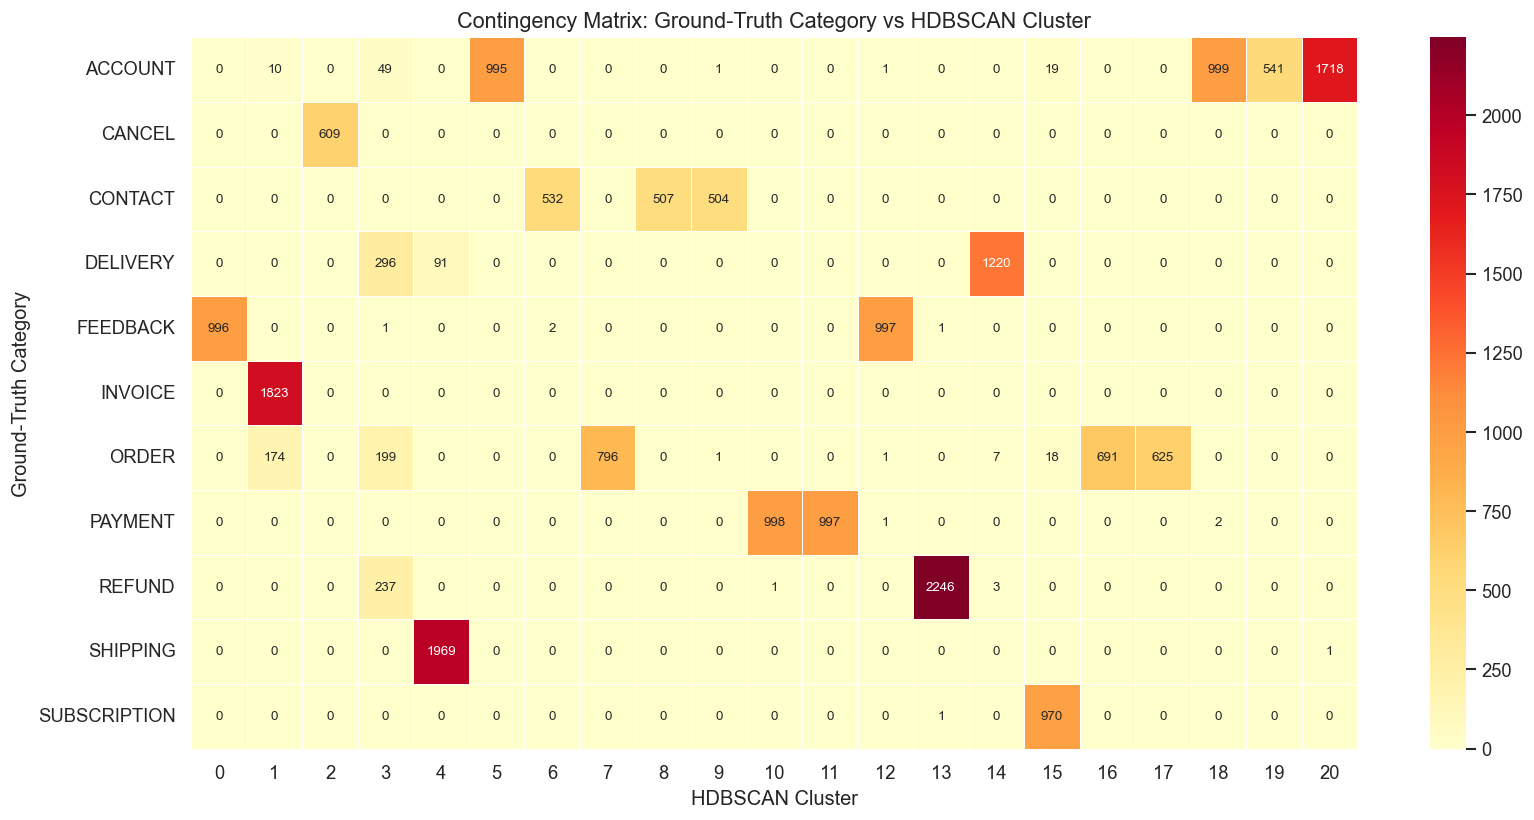

In [17]:
# Contingency matrix: Category vs HDBSCAN Cluster
ct_category = pd.crosstab(df.loc[valid_mask, "category"], df.loc[valid_mask, "hdbscan_cluster"])

fig, ax = plt.subplots(figsize=(max(14, len(ct_category.columns) * 0.6), 7))
sns.heatmap(ct_category, annot=True, fmt="d", cmap="YlOrRd", ax=ax,
            linewidths=0.3, annot_kws={"size": 8})
ax.set_title("Contingency Matrix: Ground-Truth Category vs HDBSCAN Cluster", fontsize=13)
ax.set_xlabel("HDBSCAN Cluster")
ax.set_ylabel("Ground-Truth Category")
plt.tight_layout()
plt.show()

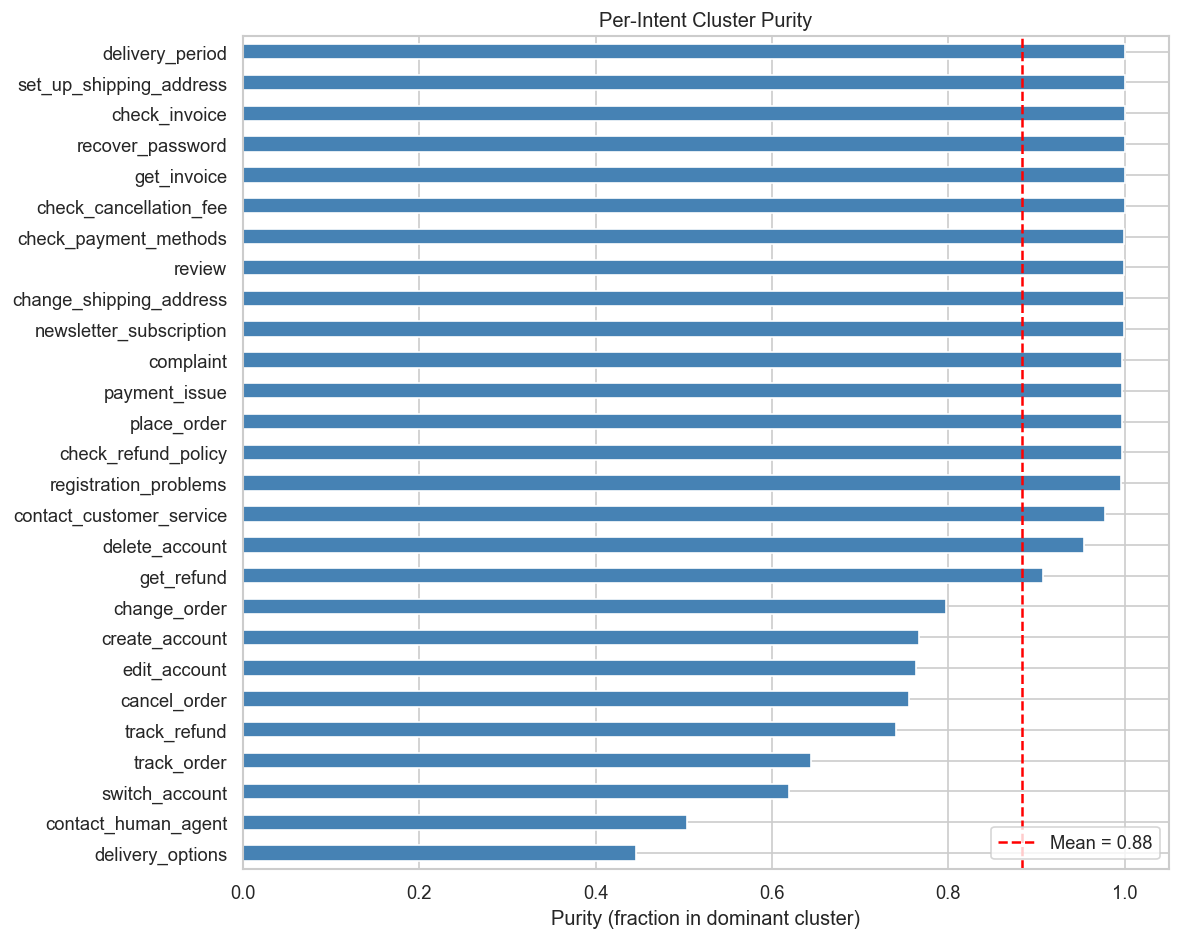


Purity stats: mean=0.883, min=0.446, max=1.000


In [18]:
# Per-intent cluster purity
# For each ground-truth intent, what fraction of its (non-noise) samples
# ended up in the single most common cluster?

purity_per_intent = {}
for intent in df.loc[valid_mask, "intent"].unique():
    mask = (df["intent"] == intent) & valid_mask
    cluster_counts = df.loc[mask, "hdbscan_cluster"].value_counts()
    purity_per_intent[intent] = cluster_counts.iloc[0] / cluster_counts.sum()

purity_series = pd.Series(purity_per_intent).sort_values()

fig, ax = plt.subplots(figsize=(10, 8))
purity_series.plot.barh(ax=ax, color="steelblue")
ax.axvline(x=purity_series.mean(), color="red", linestyle="--",
           label=f"Mean = {purity_series.mean():.2f}")
ax.set_xlabel("Purity (fraction in dominant cluster)")
ax.set_title("Per-Intent Cluster Purity")
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nPurity stats: mean={purity_series.mean():.3f}, "
      f"min={purity_series.min():.3f}, max={purity_series.max():.3f}")

## 9. Post-Hoc Cluster Labeling via TF-IDF

For each cluster, concatenate all instructions into a single "document", then compute TF-IDF.  
The **top-5 terms** (including bigrams) give a deterministic, interpretable label for each cluster.

In [19]:
valid_df = df[df["hdbscan_cluster"] != -1].copy()

# One "document" per cluster
cluster_docs = valid_df.groupby("hdbscan_cluster")["instruction"].apply(" ".join)

tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    ngram_range=(1, 2)
)
tfidf_matrix = tfidf.fit_transform(cluster_docs)
feature_names = tfidf.get_feature_names_out()

# Extract top terms per cluster
cluster_labels_tfidf = {}
print(f"{'Cluster':>8}  {'Top-5 TF-IDF Terms'}")
print("-" * 70)
for idx, cluster_id in enumerate(cluster_docs.index):
    row = tfidf_matrix[idx].toarray().flatten()
    top_indices = row.argsort()[-5:][::-1]
    top_terms = [feature_names[i] for i in top_indices]
    cluster_labels_tfidf[cluster_id] = ", ".join(top_terms)
    print(f"{cluster_id:>8}  {', '.join(top_terms)}")

 Cluster  Top-5 TF-IDF Terms
----------------------------------------------------------------------
       0  feedback, leave, send, send feedback, comment
       1  person, invoice, look, 37777, download
       2  early, exit, withdrawal, early exit, cancellation
       3  refund, delivery, country, delivery country, order
       4  address, shipping address, delivery address, delivery, shipping
       5  pin, key, user, reset, retrieve
       6  customer, customer support, customer service, support, customer assistance
       7  order, item, product, acquire, earn
       8  agent, operator, live, human agent, live agent
       9  somebody, assistant, speak, person, talk
      10  payment, payment options, payment methods, methods, modalities
      11  payment, payments, online, inform, report
      12  claim, complaint, consumer, reclamation, file
      13  money, ask, cases, refund, request
      14  arrive, soon, soon expect, expect, shipment
      15  newsletter, subscription, com

In [20]:
# Summary table: cluster TF-IDF label + dominant ground-truth intent
summary_rows = []
for cluster_id in sorted(valid_df["hdbscan_cluster"].unique()):
    mask = valid_df["hdbscan_cluster"] == cluster_id
    size = mask.sum()
    intent_counts = valid_df.loc[mask, "intent"].value_counts()
    dominant_intent = intent_counts.index[0]
    dominant_pct = intent_counts.iloc[0] / size * 100
    dominant_category = valid_df.loc[mask, "category"].value_counts().index[0]
    tfidf_label = cluster_labels_tfidf[cluster_id]
    summary_rows.append({
        "cluster": cluster_id,
        "size": size,
        "tfidf_label": tfidf_label,
        "dominant_intent": dominant_intent,
        "intent_pct": dominant_pct,
        "dominant_category": dominant_category
    })

summary_df = (
    pd.DataFrame(summary_rows)
    .sort_values("intent_pct", ascending=False)
    .reset_index(drop=True)
)
summary_df["intent_pct"] = summary_df["intent_pct"].map("{:.1f}%".format)
summary_df

,cluster,size,tfidf_label,dominant_intent,intent_pct,dominant_category
0,0,996,"feedback, leave, send, send feedback, comment",review,100.0%,FEEDBACK
1,5,995,"pin, key, user, reset, retrieve",recover_password,100.0%,ACCOUNT
2,2,609,"early, exit, withdrawal, early exit, cancellation",check_cancellation_fee,100.0%,CANCEL
3,10,999,"payment, payment options, payment methods, met...",check_payment_methods,99.9%,PAYMENT
4,11,997,"payment, payments, online, inform, report",payment_issue,99.9%,PAYMENT
5,16,691,"order, order number, number, cancel, purchase ...",cancel_order,99.7%,ORDER
6,12,1000,"claim, complaint, consumer, reclamation, file",complaint,99.7%,FEEDBACK
7,6,534,"customer, customer support, customer service, ...",contact_customer_service,99.6%,CONTACT
8,9,506,"somebody, assistant, speak, person, talk",contact_human_agent,99.4%,CONTACT
9,18,1001,"signup, sign, inform, notify, registration",registration_problems,99.3%,ACCOUNT


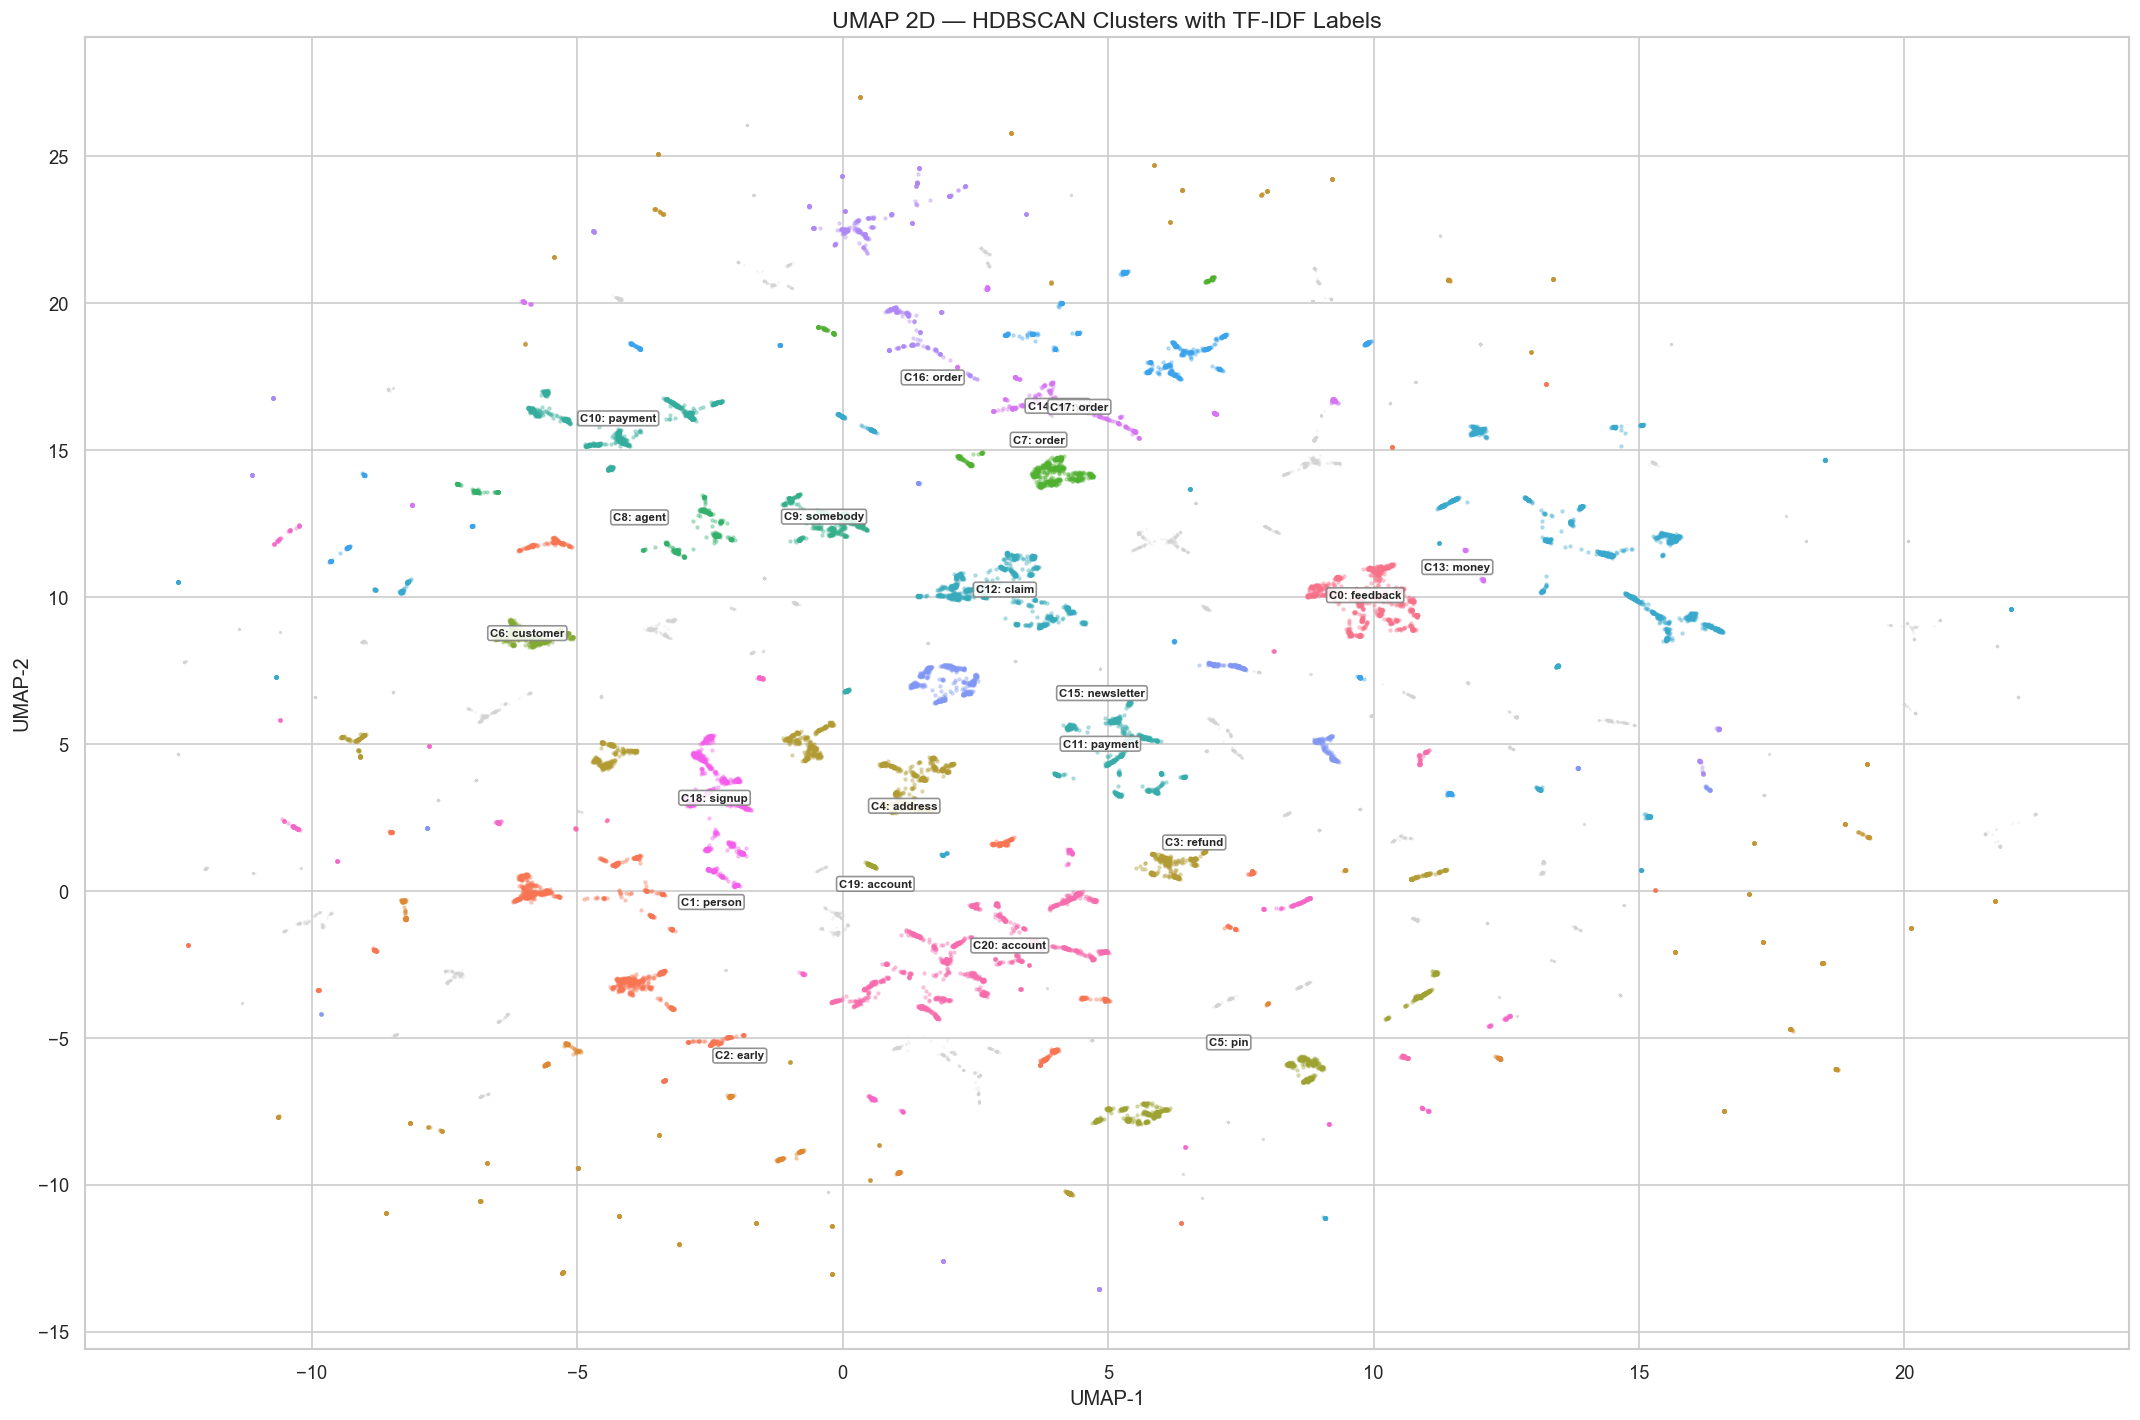

In [21]:
# Annotated UMAP plot with TF-IDF labels at cluster centroids
fig, ax = plt.subplots(figsize=(18, 12))

# Noise
if noise_mask.any():
    ax.scatter(df.loc[noise_mask, "umap_x"], df.loc[noise_mask, "umap_y"],
               c="lightgrey", s=1, alpha=0.15)

# Clusters
for i, cid in enumerate(non_noise):
    mask = df["hdbscan_cluster"] == cid
    ax.scatter(df.loc[mask, "umap_x"], df.loc[mask, "umap_y"],
               c=[palette_hdb[i]], s=3, alpha=0.3)

# Annotate centroids with TF-IDF top term
for cid in non_noise:
    mask = df["hdbscan_cluster"] == cid
    cx = df.loc[mask, "umap_x"].mean()
    cy = df.loc[mask, "umap_y"].mean()
    short_label = cluster_labels_tfidf[cid].split(",")[0].strip()
    ax.annotate(
        f"C{cid}: {short_label}",
        (cx, cy), fontsize=7, ha="center", weight="bold",
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="grey", alpha=0.85)
    )

ax.set_title("UMAP 2D — HDBSCAN Clusters with TF-IDF Labels", fontsize=14)
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
plt.tight_layout()
plt.show()

## 10. (Optional) LLM-Based Cluster Labeling

An alternative to TF-IDF: sample representative instructions from each cluster (closest to centroid) and prompt an LLM to generate a descriptive label.

> **Note:** This section requires an API key. The code below constructs prompts and prints them. Uncomment the API call lines to run live.

In [24]:
from dotenv import load_dotenv
import anthropic

load_dotenv()  # loads variables from .env file

client = anthropic.Anthropic()  # uses ANTHROPIC_API_KEY env var

def get_representative_samples(df, cluster_id, embeddings, n=8):
    """Return the n instructions closest to the cluster centroid."""
    mask = (df["hdbscan_cluster"] == cluster_id).values
    cluster_embs = embeddings[mask]
    centroid = cluster_embs.mean(axis=0)
    distances = np.linalg.norm(cluster_embs - centroid, axis=1)
    closest_idx = distances.argsort()[:n]
    return df.loc[mask, "instruction"].iloc[closest_idx].tolist()


llm_labels = {}
for cid in sorted(valid_df["hdbscan_cluster"].unique()):
    samples = get_representative_samples(df, cid, embeddings)
    prompt = (
        "Below are representative customer support utterances from a single cluster.\n"
        "Generate a short (2–5 word) descriptive label for this cluster.\n"
        "Reply with ONLY the label, nothing else.\n\n"
        "Utterances:\n"
        + "\n".join(f"- {s}" for s in samples)
        + "\n\nLabel:"
    )
    print(f"{'='*60}")
    print(f"CLUSTER {cid}  (TF-IDF label: {cluster_labels_tfidf[cid].split(',')[0].strip()})")
    print(f"{'='*60}")

    response = client.messages.create(
        model="claude-sonnet-4-5-20250929",
        max_tokens=30,
        messages=[{"role": "user", "content": prompt}],
    )
    label = response.content[0].text.strip()
    llm_labels[cid] = label
    print(f"  LLM Label: {label}\n")

# Add LLM labels to summary_df
summary_df["llm_label"] = summary_df["cluster"].map(llm_labels)
summary_df

CLUSTER 0  (TF-IDF label: feedback)
  LLM Label: Submit Product Feedback

CLUSTER 1  (TF-IDF label: person)
  LLM Label: Find Bill from Person

CLUSTER 2  (TF-IDF label: early)
  LLM Label: Check withdrawal fee

CLUSTER 3  (TF-IDF label: refund)
  LLM Label: Order Management Inquiries

CLUSTER 4  (TF-IDF label: address)
  LLM Label: Change Delivery Address

CLUSTER 5  (TF-IDF label: pin)
  LLM Label: Recover Account PIN

CLUSTER 6  (TF-IDF label: customer)
  LLM Label: Contact Customer Support

CLUSTER 7  (TF-IDF label: order)
  LLM Label: Purchasing Multiple Items

CLUSTER 8  (TF-IDF label: agent)
  LLM Label: Speak with agent assistance

CLUSTER 9  (TF-IDF label: somebody)
  LLM Label: Request Human Agent Assistance

CLUSTER 10  (TF-IDF label: payment)
  LLM Label: View Available Payment Methods

CLUSTER 11  (TF-IDF label: payment)
  LLM Label: Report Payment Problems

CLUSTER 12  (TF-IDF label: claim)
  LLM Label: Lodge Customer Claim

CLUSTER 13  (TF-IDF label: money)
  LLM Label: 

,cluster,size,tfidf_label,dominant_intent,intent_pct,dominant_category,llm_label
0,0,996,"feedback, leave, send, send feedback, comment",review,100.0%,FEEDBACK,Submit Product Feedback
1,5,995,"pin, key, user, reset, retrieve",recover_password,100.0%,ACCOUNT,Recover Account PIN
2,2,609,"early, exit, withdrawal, early exit, cancellation",check_cancellation_fee,100.0%,CANCEL,Check withdrawal fee
3,10,999,"payment, payment options, payment methods, met...",check_payment_methods,99.9%,PAYMENT,View Available Payment Methods
4,11,997,"payment, payments, online, inform, report",payment_issue,99.9%,PAYMENT,Report Payment Problems
5,16,691,"order, order number, number, cancel, purchase ...",cancel_order,99.7%,ORDER,Cancel Order Assistance Request
6,12,1000,"claim, complaint, consumer, reclamation, file",complaint,99.7%,FEEDBACK,Lodge Customer Claim
7,6,534,"customer, customer support, customer service, ...",contact_customer_service,99.6%,CONTACT,Contact Customer Support
8,9,506,"somebody, assistant, speak, person, talk",contact_human_agent,99.4%,CONTACT,Request Human Agent Assistance
9,18,1001,"signup, sign, inform, notify, registration",registration_problems,99.3%,ACCOUNT,Report Signup Problems


## 11. Summary & Key Findings

In [23]:
print("=" * 60)
print("  CLUSTERING ANALYSIS SUMMARY")
print("=" * 60)
print(f"  Embedding model:           {MODEL_NAME}")
print(f"  Embedding dimensions:      {embeddings.shape[1]}")
print(f"  UMAP cluster dims:         {embeddings_umap_cluster.shape[1]}")
print(f"  HDBSCAN min_cluster_size:  {int(best_mcs)}")
print(f"  HDBSCAN clusters found:    {n_clusters}")
print(f"  Noise points:              {n_noise:,} ({n_noise / len(df) * 100:.1f}%)")
print(f"  ─────────────────────────────────────────")
print(f"  Against INTENT (27 classes):")
print(f"    ARI = {ari_intent:.4f}")
print(f"    NMI = {nmi_intent:.4f}")
print(f"  Against CATEGORY (11 classes):")
print(f"    ARI = {ari_category:.4f}")
print(f"    NMI = {nmi_category:.4f}")
print(f"  ─────────────────────────────────────────")
print(f"  Mean per-intent purity:    {purity_series.mean():.3f}")
print(f"  Min per-intent purity:     {purity_series.min():.3f}")
print("=" * 60)

  CLUSTERING ANALYSIS SUMMARY
  Embedding model:           all-MiniLM-L6-v2
  Embedding dimensions:      384
  UMAP cluster dims:         15
  HDBSCAN min_cluster_size:  500
  HDBSCAN clusters found:    21
  Noise points:              5,022 (18.7%)
  ─────────────────────────────────────────
  Against INTENT (27 classes):
    ARI = 0.6961
    NMI = 0.8751
  Against CATEGORY (11 classes):
    ARI = 0.6317
    NMI = 0.8368
  ─────────────────────────────────────────
  Mean per-intent purity:    0.883
  Min per-intent purity:     0.446
